In [7]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from tflearning.sample_difficulty.plot import plot_pruning_results_fixed_samples


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 25 Finetune resnet18 on cifar10

Steps: 
- [x] do hypsearch on full dataset
- [x] select random samples (prune randomly)
- [x] select samples according to prediction depth metric

## A. Experiment config

### Config file

In [4]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: wasp
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: trainer.optimizer.kwargs.lr
    vals: [5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  - parameter: trainer.optimizer.kwargs.weight_decay
    vals: [0.0, 1e-3, 1e-4]
    
start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '25'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-hypsearch
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 20
    val_every: 1
    early_stopping_patience: 5
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 1e-3
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
"""
cfg = OmegaConf.create(config_yaml)

In [5]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

### Sweep result

In [6]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 25(0)
Exp. Name: cifar10-25.0-resnet18-ft-hypsearch
Training setup: finetune
Model name: timmmodel
Dataset name: cifar10
Sweep type: grid
  trainer.optimizer.kwargs.lr: [0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05]
  trainer.optimizer.kwargs.weight_decay: [0.0, 0.001, 0.0001]
Seeds: [0]
Num. jobs: 18
Config updated: 2023-03-12 20:57:46
Sweep started:  2023-03-12 20:58:08



In [7]:
failed_jobs = sweepr.get_failed_jobs()
failed_jobs # No failed jobs

([], {})

In [8]:
sweepr.get_summary().sort_values(by='best_val_score', ascending=True)

,best_epoch,best_val_score,trainer.optimizer.kwargs.lr,trainer.optimizer.kwargs.weight_decay,seed
cifar10-25.0-resnet18-ft-hypsearch--lr-5e-05-weight_decay-0-seed-0--230312_215540,5,0.140873,0.00005,0.0000,0
cifar10-25.0-resnet18-ft-hypsearch--lr-5e-05-weight_decay-0.0001-seed-0--230312_215628,5,0.140873,0.00005,0.0001,0
cifar10-25.0-resnet18-ft-hypsearch--lr-5e-05-weight_decay-0.001-seed-0--230312_215543,7,0.141192,0.00005,0.0010,0
cifar10-25.0-resnet18-ft-hypsearch--lr-0.0001-weight_decay-0-seed-0--230312_213710,8,0.141804,0.00010,0.0000,0
cifar10-25.0-resnet18-ft-hypsearch--lr-0.0001-weight_decay-0.0001-seed-0--230312_214109,8,0.141804,0.00010,0.0001,0
cifar10-25.0-resnet18-ft-hypsearch--lr-0.0001-weight_decay-0.001-seed-0--230312_214013,5,0.145786,0.00010,0.0010,0
cifar10-25.0-resnet18-ft-hypsearch--lr-1e-05-weight_decay-0-seed-0--230312_220028,19,0.148364,0.00001,0.0000,0
cifar10-25.0-resnet18-ft-hypsearch--lr-1e-05-weight_decay-0.0001-seed-0--230312_221146,19,0.148364,0.00001,0.0001,0
cifar10-25.0-resnet18-ft-hypsearch--lr-1e-05-weight_decay-0.001-seed-0--230312_221106,19,0.148364,0.00001,0.0010,0
cifar10-25.0-resnet18-ft-hypsearch--lr-0.0005-weight_decay-0.0001-seed-0--230312_213639,8,0.194139,0.00050,0.0001,0


## B. Random subsample sweep

In [12]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: wasp
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
    
start_num: 1

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '25.1'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-randomsubsample
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 100
    val_every: 1
    early_stopping_patience: 30
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 0.00005
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
    sample_selector:
      name: random
      kwargs:
        fraction: 0.1

"""
cfg = OmegaConf.create(config_yaml)

In [13]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [14]:
sweepr_randsample = REPO.get_output_loader(cfg)
print(sweepr_randsample)

Exp. Tag(start_num): 25.1(1)
Exp. Name: cifar10-25.1.1-resnet18-ft-randomsubsample
Training setup: finetune
Model name: timmmodel
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
Seeds: [0]
Num. jobs: 8
Config updated: 2023-03-13 11:50:44
Sweep started:  2023-03-13 11:50:59



In [18]:
sweepr_randsample.get_summary()

,best_epoch,best_val_score,data.sample_selector.kwargs.fraction,seed
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-0.1-seed-0--230313_115120,13,0.299969,0.1,0
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-0.2-seed-0--230313_115121,12,0.232194,0.2,0
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-0.4-seed-0--230313_115123,14,0.191623,0.4,0
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-0.5-seed-0--230313_115124,8,0.179207,0.5,0
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-0.6-seed-0--230313_120208,7,0.172786,0.6,0
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-0.7-seed-0--230313_120716,10,0.163319,0.7,0
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-0.8-seed-0--230313_121910,8,0.154825,0.8,0
cifar10-25.1.1-resnet18-ft-randomsubsample--fraction-1-seed-0--230313_121947,8,0.148156,1.0,0


## C. Pred Depth subsample sweep

In [15]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: ocelot
  gpu_ids: [0]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
  - parameter: data.sample_selector.kwargs.keep_highest
    vals: [True, False]
    
start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '25.2-cf10-pd_subsample'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-pdepthsubsample
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 50
    val_every: 1
    early_stopping_patience: 20
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 0.00005
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
    sample_selector:
      name: prediction_depth
      kwargs:
        fraction: 0.1
        pred_results_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-cifar10_resnet18-pretrained--230317_124927/prediction_depth_results.p
        keep_highest: True
"""
cfg = OmegaConf.create(config_yaml)

In [16]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [17]:
sweepr_pdsample = REPO.get_output_loader(cfg)
print(sweepr_pdsample)

Exp. Tag(start_num): 25.2-cf10-pd_subsample(0)
Exp. Name: cifar10-25.2-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample
Training setup: finetune
Model name: timmmodel
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
  data.sample_selector.kwargs.keep_highest: [True, False]
Seeds: [0]
Num. jobs: 16
Config updated: 2023-03-18 08:53:20
Sweep started:  2023-03-18 08:55:07



## D. Make results plots

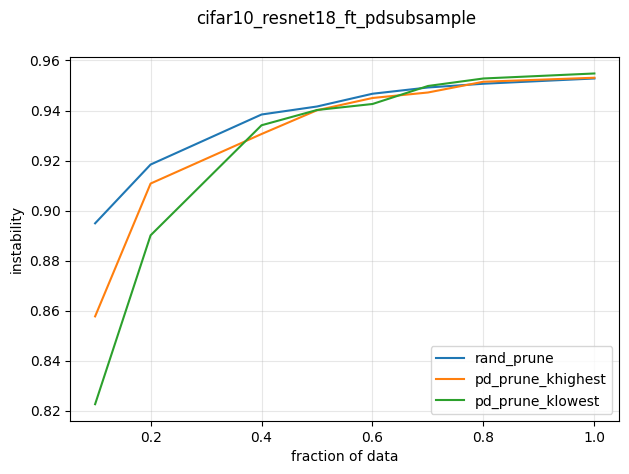

In [62]:
from tflearning.sample_difficulty.plot import plot_pruning_results

f = plot_pruning_results(random_pruning_results=sweepr_randsample,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='')

## E. Random subsample sweep (fix n_samples)

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: wasp
  gpu_ids: [2,3]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.2, 0.4, 0.6, 0.8, 1.0]
  - parameter: data.sample_selector.kwargs.restrict_n_samples
    vals: [1000, 5000, 10000]
    
start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '25.3-cf10-randsample'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-randomsubsample
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 30
    val_every: 1
    early_stopping_patience: 15
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 0.00005
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
    sample_selector:
      name: random
      kwargs:
        fraction: 0.1
        restrict_n_samples: -1

"""
cfg = OmegaConf.create(config_yaml)

In [3]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [4]:
sweepr_randsample = REPO.get_output_loader(cfg)
print(sweepr_randsample)

Exp. Tag(start_num): 25.3-cf10-randsample(0)
Exp. Name: cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample
Training setup: finetune
Model name: timmmodel
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.6, 0.8, 1.0]
  data.sample_selector.kwargs.restrict_n_samples: [1000, 5000, 10000]
Seeds: [0]
Num. jobs: 15
Config updated: 2023-03-20 14:31:59
Sweep started:  2023-03-20 14:16:41



In [5]:
sweepr_randsample.get_failed_jobs()

([], {})

In [30]:
ft_epoch = 10
ft_col_sel = 'Accuracy-top-1'
ft_row_sel = ('epoch', ft_epoch)
col_name = f'{ft_col_sel}-{ft_row_sel[0]}-{ft_row_sel[1]}'
df = sweepr_randsample.get_summary(log_source='val', col_sel=ft_col_sel, row_sel=ft_row_sel)
df

,best_epoch,best_val_score,Accuracy-top-1-epoch-10,data.sample_selector.kwargs.fraction,data.sample_selector.kwargs.restrict_n_samples,seed
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.2-restrict_n_samples-1000-seed-0--230320_141659,30,0.524865,0.7431,0.2,1000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.2-restrict_n_samples-10000-seed-0--230320_142149,10,0.228765,0.9281,0.2,10000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.2-restrict_n_samples-5000-seed-0--230320_141659,18,0.290690,0.9024,0.2,5000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.4-restrict_n_samples-1000-seed-0--230320_142441,30,0.504065,0.7422,0.4,1000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.4-restrict_n_samples-10000-seed-0--230320_143125,10,0.228436,0.9249,0.4,10000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.4-restrict_n_samples-5000-seed-0--230320_142850,16,0.289590,0.8988,0.4,5000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.6-restrict_n_samples-1000-seed-0--230320_143558,30,0.538845,0.7231,0.6,1000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.6-restrict_n_samples-10000-seed-0--230320_144103,9,0.228669,0.9220,0.6,10000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.6-restrict_n_samples-5000-seed-0--230320_144014,15,0.290066,0.8986,0.6,5000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.8-restrict_n_samples-1000-seed-0--230320_144727,30,0.521573,0.7003,0.8,1000,0


In [ ]:
def _convert_to_series(df: pd.DataFrame, val_col: str, ind_col: str) -> pd.Series:
    return df[[val_col, ind_col]].set_index(ind_col).squeeze()
def get_samples_accuracy_series(df: pd.DataFrame, label: str='', y_col_name: str = 'Accuracy-top-1-epoch-10'):
    ss_dict = {}
    for fraction in df['data.sample_selector.kwargs.fraction'].unique():
        ss = _convert_to_series(df[df['data.sample_selector.kwargs.fraction'] == fraction], y_col_name, 'data.sample_selector.kwargs.restrict_n_samples')
        ss_dict[f'{label}-frac{fraction}'] = ss
    return ss_dict
 

In [47]:
df[df['data.sample_selector.kwargs.fraction'] == 0.2]

,best_epoch,best_val_score,Accuracy-top-1-epoch-10,data.sample_selector.kwargs.fraction,data.sample_selector.kwargs.restrict_n_samples,seed
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.2-restrict_n_samples-1000-seed-0--230320_141659,30,0.524865,0.7431,0.2,1000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.2-restrict_n_samples-10000-seed-0--230320_142149,10,0.228765,0.9281,0.2,10000,0
cifar10-25.3-cf10-randsample.0-resnet18-ft-randomsubsample--fraction-0.2-restrict_n_samples-5000-seed-0--230320_141659,18,0.290690,0.9024,0.2,5000,0


## F. Pred Depth subsample sweep (fix n_samples)

In [18]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: scorpion
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [1.0] #[0.2, 0.4, 0.6, 0.8, 1.0]
  - parameter: data.sample_selector.kwargs.restrict_n_samples
    vals: [1000, 5000, 10000]
  - parameter: data.sample_selector.kwargs.keep_highest
    vals: [True, False]
    
start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '25.4-cf10-pd_subsample'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-pdepthsubsample
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 30
    val_every: 1
    early_stopping_patience: 15
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 0.00005
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
    sample_selector:
      name: prediction_depth
      kwargs:
        fraction: 0.1
        pred_results_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-cifar10_resnet18-pretrained--230317_124927/prediction_depth_results.p
        keep_highest: True
"""
cfg = OmegaConf.create(config_yaml)

In [19]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample.yaml


In [8]:
sweepr_pdsample = REPO.get_output_loader(cfg)
print(sweepr_pdsample)

Exp. Tag(start_num): 25.4-cf10-pd_subsample(0)
Exp. Name: cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample
Training setup: finetune
Model name: timmmodel
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.6, 0.8, 1.0]
  data.sample_selector.kwargs.restrict_n_samples: [1000, 5000, 10000]
  data.sample_selector.kwargs.keep_highest: [True, False]
Seeds: [0]
Num. jobs: 30
Config updated: 2023-03-20 14:33:34
Sweep started:  2023-03-20 14:34:46



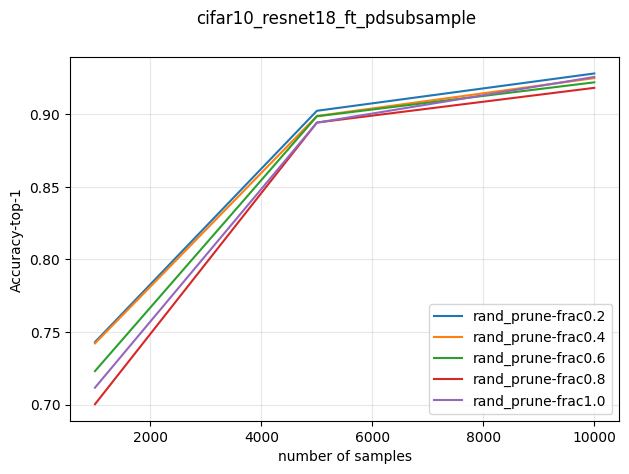

In [58]:

f = plot_pruning_results_fixed_samples(random_pruning_results=sweepr_randsample,
                         pd_pruning_results=None,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='')

Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-0-seed-0--230320_162740
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-1-seed-0--230320_162723
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-10000-keep_highest-0-seed-0--230320_162836
Could not find job /system/user/publicwork/beck/projects/regularization/

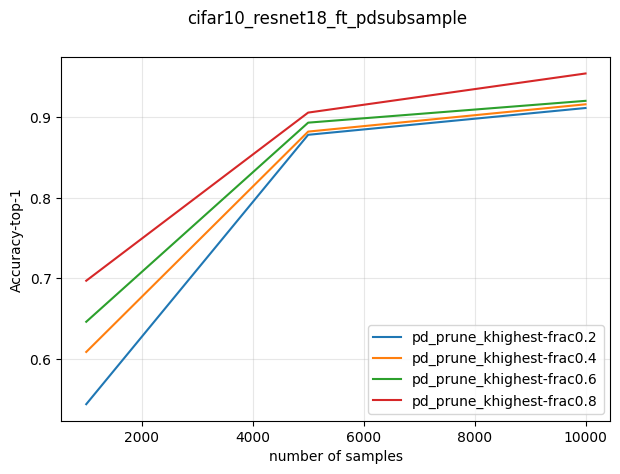

In [59]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         keep_highest=True)

Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-0-seed-0--230320_162740
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-1-seed-0--230320_162723
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-10000-keep_highest-0-seed-0--230320_162836
Could not find job /system/user/publicwork/beck/projects/regularization/

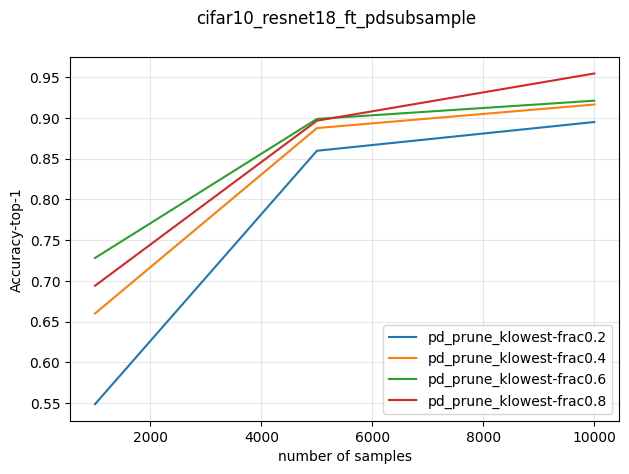

In [60]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         keep_highest=False)

Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-0-seed-0--230320_162740
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-1-seed-0--230320_162723
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-10000-keep_highest-0-seed-0--230320_162836
Could not find job /system/user/publicwork/beck/projects/regularization/

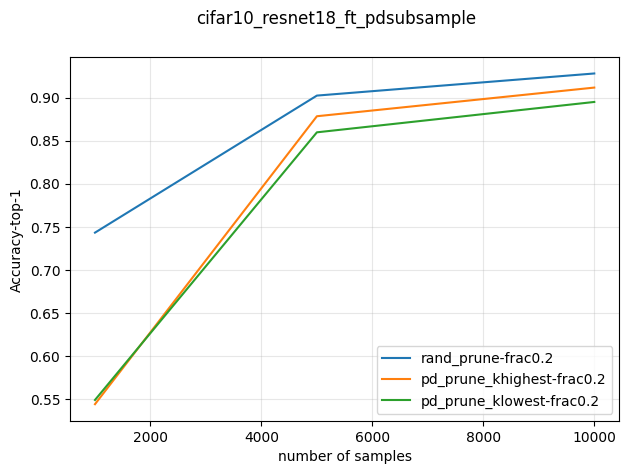

In [49]:
f = plot_pruning_results_fixed_samples(random_pruning_results=sweepr_randsample,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=[0.2])

Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-0-seed-0--230320_162740
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-1-seed-0--230320_162723
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-10000-keep_highest-0-seed-0--230320_162836
Could not find job /system/user/publicwork/beck/projects/regularization/

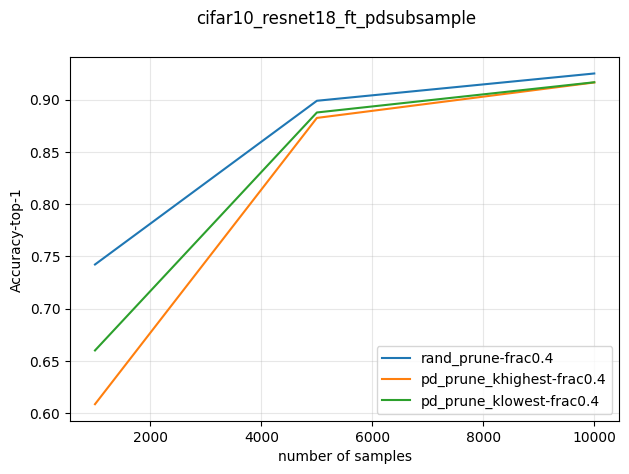

In [54]:
f = plot_pruning_results_fixed_samples(random_pruning_results=sweepr_randsample,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=[0.4])

Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-0-seed-0--230320_162740
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-1-seed-0--230320_162723
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-10000-keep_highest-0-seed-0--230320_162836
Could not find job /system/user/publicwork/beck/projects/regularization/

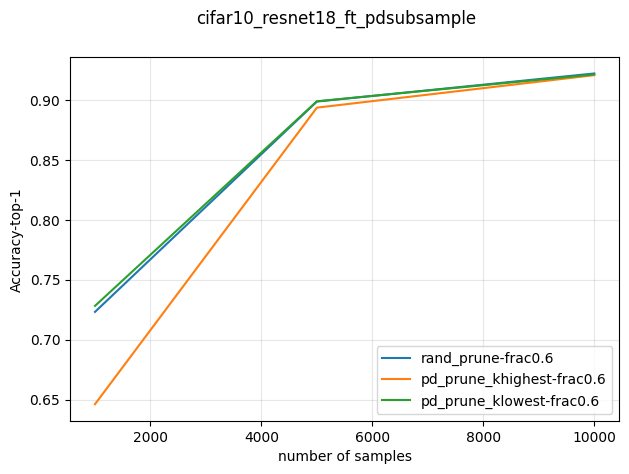

In [55]:
f = plot_pruning_results_fixed_samples(random_pruning_results=sweepr_randsample,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=[0.6])

Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-0-seed-0--230320_162740
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-1000-keep_highest-1-seed-0--230320_162723
Could not find job /system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--230320_143446/outputs/cifar10-25.4-cf10-pd_subsample.0-resnet18-ft-pdepthsubsample--fraction-1-restrict_n_samples-10000-keep_highest-0-seed-0--230320_162836
Could not find job /system/user/publicwork/beck/projects/regularization/

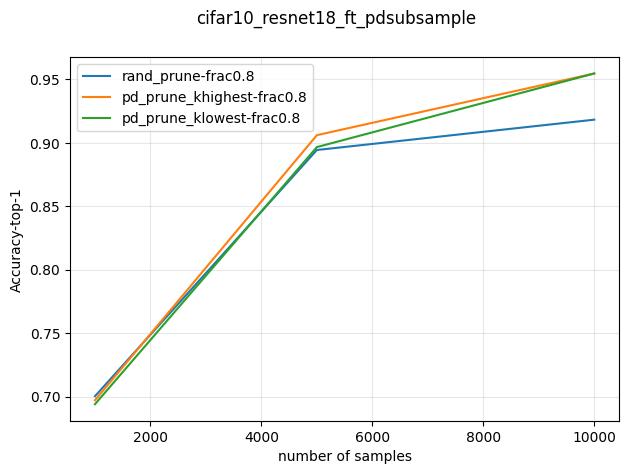

In [56]:
f = plot_pruning_results_fixed_samples(random_pruning_results=sweepr_randsample,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=[0.8])

## G. Pred Depth subsample Class balance

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: scorpion
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.2, 0.4, 0.6, 0.8, 1.0]
  - parameter: data.sample_selector.kwargs.restrict_n_samples
    vals: [1000, 5000, 10000]
  - parameter: data.sample_selector.kwargs.keep_highest
    vals: [True, False]
    
start_num: 1

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '25.5-cf10-pd_cl_balance'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-pdepthsubsample
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 50
    val_every: 1
    early_stopping_patience: 30
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 0.00005
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
    sample_selector:
      name: prediction_depth_class_balance
      kwargs:
        fraction: 0.1
        pred_results_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-cifar10_resnet18-pretrained--230317_124927/prediction_depth_results.p
        keep_highest: True
        restrict_n_samples: 1000
"""
cfg = OmegaConf.create(config_yaml)

In [3]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [4]:
sweepr_pdsample = REPO.get_output_loader(cfg)
print(sweepr_pdsample)

Exp. Tag(start_num): 25.5-cf10-pd_cl_balance(1)
Exp. Name: cifar10-25.5-cf10-pd_cl_balance.1-resnet18-ft-pdepthsubsample
Training setup: finetune
Model name: timmmodel
Dataset name: cifar10
Sweep type: grid
  data.sample_selector.kwargs.fraction: [0.2, 0.4, 0.6, 0.8, 1.0]
  data.sample_selector.kwargs.restrict_n_samples: [1000, 5000, 10000]
  data.sample_selector.kwargs.keep_highest: [True, False]
Seeds: [0]
Num. jobs: 30
Config updated: 2023-03-21 17:28:23
Sweep started:  2023-03-21 17:27:05



In [5]:
sweepr_pdsample.get_failed_jobs()

([], {})

In [8]:
sweepr_pdsample.get_summary().head()

,best_epoch,best_val_score,data.sample_selector.kwargs.fraction,data.sample_selector.kwargs.restrict_n_samples,data.sample_selector.kwargs.keep_highest,seed
cifar10-25.5-cf10-pd_cl_balance.1-resnet18-ft-pdepthsubsample--fraction-0.2-restrict_n_samples-1000-keep_highest-0-seed-0--230321_172730,45,0.554028,0.2,1000,False,0
cifar10-25.5-cf10-pd_cl_balance.1-resnet18-ft-pdepthsubsample--fraction-0.2-restrict_n_samples-1000-keep_highest-1-seed-0--230321_172728,43,0.521302,0.2,1000,True,0
cifar10-25.5-cf10-pd_cl_balance.1-resnet18-ft-pdepthsubsample--fraction-0.2-restrict_n_samples-10000-keep_highest-0-seed-0--230321_173504,14,0.285011,0.2,10000,False,0
cifar10-25.5-cf10-pd_cl_balance.1-resnet18-ft-pdepthsubsample--fraction-0.2-restrict_n_samples-10000-keep_highest-1-seed-0--230321_173503,9,0.263144,0.2,10000,True,0
cifar10-25.5-cf10-pd_cl_balance.1-resnet18-ft-pdepthsubsample--fraction-0.2-restrict_n_samples-5000-keep_highest-0-seed-0--230321_172732,17,0.338760,0.2,5000,False,0


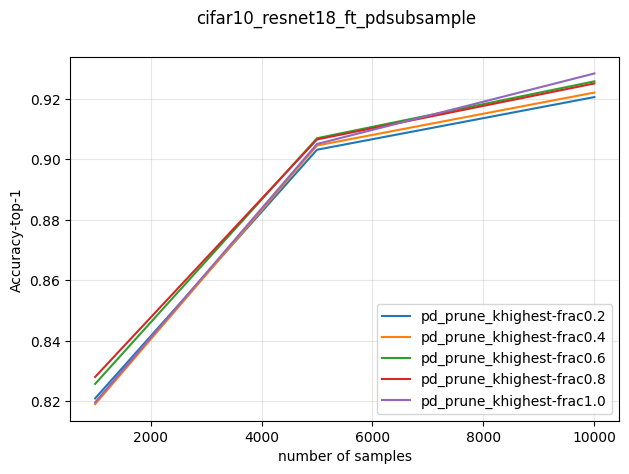

In [21]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=30,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=None, 
                         keep_highest=True)

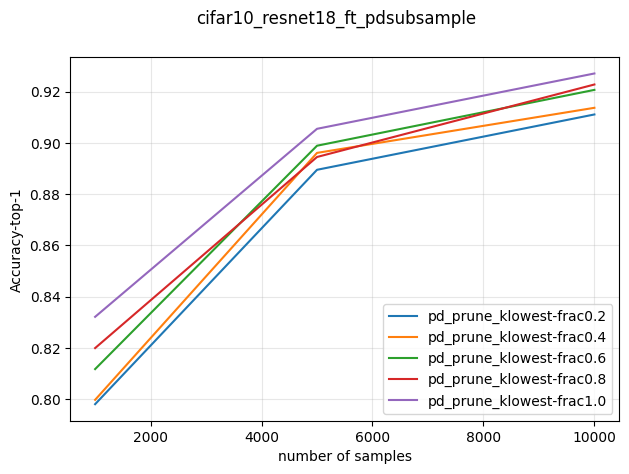

In [22]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=30,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=None, 
                         keep_highest=False)

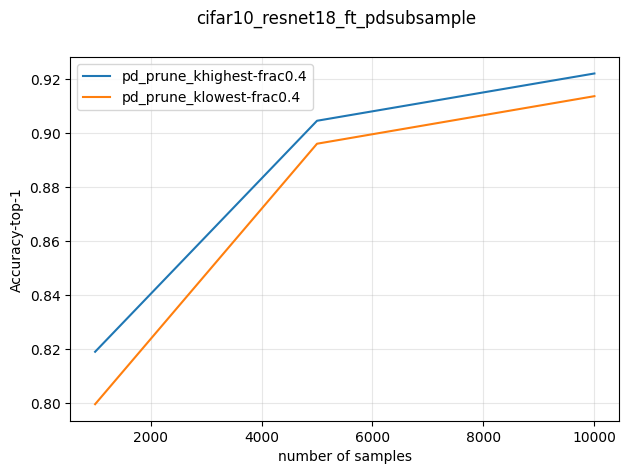

In [18]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=30,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=[0.4])

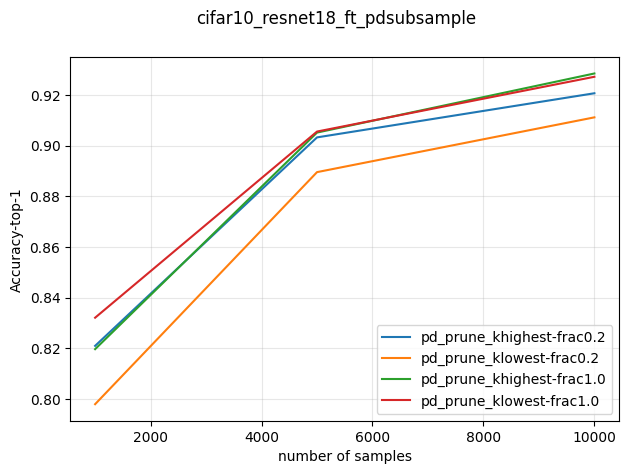

In [20]:
f = plot_pruning_results_fixed_samples(random_pruning_results=None,
                         pd_pruning_results=sweepr_pdsample,
                         title='cifar10_resnet18_ft_pdsubsample',
                         ft_epoch=30,
                         ft_col_sel='Accuracy-top-1',
                         save_format='', 
                         fractions=[0.2, 1.0])